In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
x = np.load("/home/eric.moreno/combined_heuristics_data_11k.npy")#, mmap_mode='r')

In [3]:
heuristic_model = "/home/katya.govorkova/gwak-paper-final-models/trained/model_heuristic.h5"
import torch.nn as nn
class BasedModel(nn.Module):
    def __init__(self):
        super(BasedModel, self).__init__()

        self.layer1 = nn.Linear(3, 1)
        self.layer2_1 = nn.Linear(1, 1)
        self.layer2_2 = nn.Linear(1, 1)
        self.layer2_3 = nn.Linear(1, 1)
        
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x1 = self.activation(self.layer1(x[:, :3]))
        # x2_1 = self.activation(self.layer2_1(x[:, 3:4]))
        # x2_2 = self.activation(self.layer2_2(x[:, 4:5]))
        # x2_3 = self.activation(self.layer2_3(x[:, 5:6]))
        x2_1 = self.activation(self.layer2_1(x[:, 3:4]))
        x2_2 = self.activation(self.layer2_1(x[:, 4:5]))
        x2_3 = self.activation(self.layer2_1(x[:, 5:6]))
        return x1 * x2_1 * x2_2 * x2_3

In [4]:
model = BasedModel()
model.load_state_dict(torch.load(heuristic_model, map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
original_scores = x[:, -1]
heuristic_features = x[:, :-1]

In [6]:
model_input = torch.from_numpy(heuristic_features).float()
scored = model.forward(model_input).detach().numpy()

In [7]:
def sig_prob_function(evals, scale=40):
    sigmoid = lambda x: 1/(1+np.exp(-x))
    #sigmoid = lambda x: 1/(1+np.exp(-(x-0.3)))
    return 1-(sigmoid(scale * (evals-0.5)))
reweighting_factors = sig_prob_function(scored)

In [8]:
reweighted_scores = original_scores * reweighting_factors[:, 0]

In [9]:
sanity_filter = np.logical_and(original_scores > -50, original_scores < 0)
original_scores = original_scores[sanity_filter]
reweighted_scores = reweighted_scores[sanity_filter]

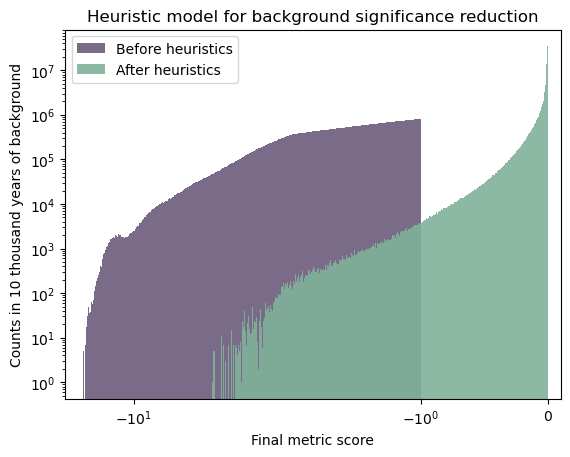

In [10]:
plt.style.use('default')
plt.hist(original_scores, bins=1500, color="#6c5b7b", alpha=0.9, label = 'Before heuristics')
plt.hist(reweighted_scores, bins=1500, color="#81b29a", alpha=0.9, label = 'After heuristics')
# plt.grid()
plt.yscale("log")
plt.xlabel("Final metric score")
plt.xscale("symlog")
plt.xlim((-20,0.1))
plt.ylabel("Counts in 10 thousand years of background")
plt.title("Heuristic model for background significance reduction")
plt.legend()
plt.savefig('plots/heuristics.png')

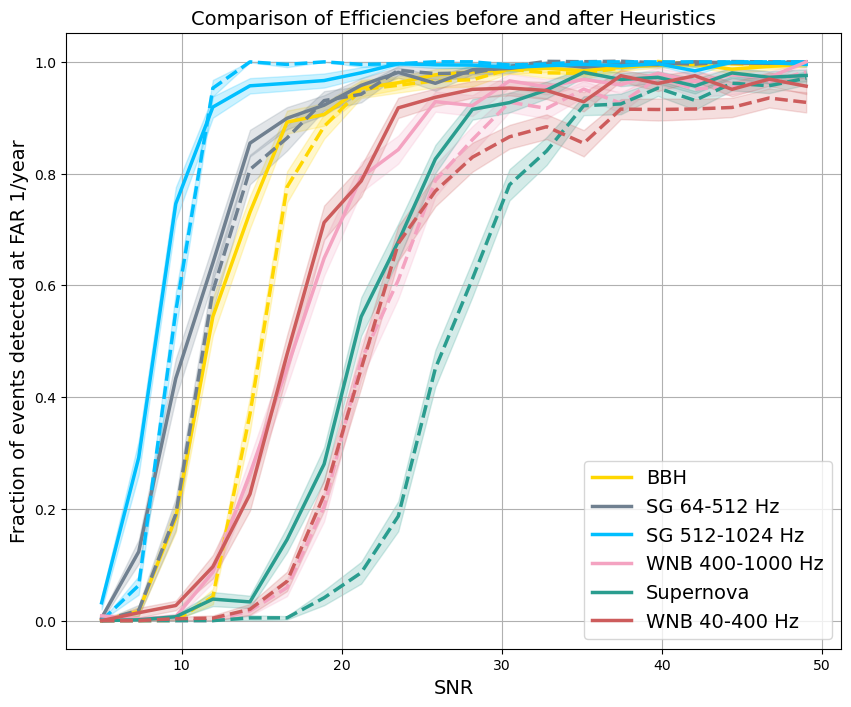

In [24]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Load the .npz files
data_after = np.load("plots/eff_after_heuristics.npz")
data_before = np.load("plots/eff_before_heuristics.npz")

# Verify that both files have the same keys
assert set(data_after.keys()) == set(data_before.keys()), "Keys in the files do not match."

# Define colors for each key
cols = [
    "#ffd700",  # BBH (Yellow - Gold)
    "#708090",  # SGLF (Light Slate Gray)
    "#00bfff",  # SGHF (Deep Sky Blue)
    "#f4a3c1",  # Background (Soft Pink)
    "#2a9d8f",  # Glitch (Emerald Green)
    "#cd5c5c",  # Freq Corr (Indian Red)
    "#006400",  # Final Metric (Dark Green)
    "#daa520",  # Hanford (Goldenrod)
    "#ff6347",  # Livingston (Tomato)
]

# Map for renaming keys in the legend
rename_map = {
    'background': 'Background',
    'bbh': 'BBH',
    'glitches': 'Glitch',
    'sglf': 'SG 64-512 Hz',
    'sghf': 'SG 512-1024 Hz',
    'wnblf': 'WNB 40-400 Hz',
    'wnbhf': 'WNB 400-1000 Hz',
    'supernova': 'Supernova'
}

# Initialize the plot
plt.figure(figsize=(10, 8))

# Loop through each key and plot the curves
for i, key in enumerate(data_after.keys()):
    # Extract x and y values for both datasets
    x_after, y_after, y_error_after = data_after[key]
    x_before, y_before, y_error_before = data_before[key]
    key_ = rename_map[key]

    # Interpolation for smoothing
    x_smooth_after = np.linspace(x_after.min(), x_after.max(), 20)
    x_smooth_before = np.linspace(x_before.min(), x_before.max(), 20)
    
    y_smooth_after = make_interp_spline(x_after, y_after)(x_smooth_after)
    y_smooth_before = make_interp_spline(x_before, y_before)(x_smooth_before)
    
    y_error_smooth_after = make_interp_spline(x_after, y_error_after)(x_smooth_after)
    y_error_smooth_before = make_interp_spline(x_before, y_error_before)(x_smooth_before)

    # Plot the smoothed curves
    plt.plot(x_smooth_after, y_smooth_after, label=f"{key_}", linestyle='-', color=cols[i], linewidth=2.5)
    plt.plot(x_smooth_before, y_smooth_before, linestyle='--', color=cols[i], linewidth=2.5)

    # Add shaded uncertainty bands for the smoothed curves
    plt.fill_between(x_smooth_after, y_smooth_after - y_error_smooth_after, y_smooth_after + y_error_smooth_after, color=cols[i], alpha=0.2)
    plt.fill_between(x_smooth_before, y_smooth_before - y_error_smooth_before, y_smooth_before + y_error_smooth_before, color=cols[i], alpha=0.2)

# Add labels, legend, and title
plt.xlabel("SNR", fontsize=14)
plt.ylabel("Fraction of events detected at FAR 1/year", fontsize=14)
plt.title("Comparison of Efficiencies before and after Heuristics", fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)

# Display the plot
plt.savefig('plots/heuristics.png')
# plt.show()
